In [1]:
import pytorch_lightning as pl
from src import Model, DataModule

In [2]:
size = 256
config = {
    # optimization
    'lr': 3e-4,
    'optimizer': 'Adam',
    'batch_size': 128,
    # data
    'extra_data': 1,
    'subset': 0.1,
    'num_workers': 20,
    # model
    'backbone': 'seresnext50_32x4d',
    'pretrained': True,
    'unfreeze': 0,
    # data augmentation
    'size': size,
    'train_trans': {
        'RandomCrop': {
            'height': size, 
            'width': size
        },
        'HorizontalFlip': {},
        'VerticalFlip': {},
        'Normalize': {}
    },
    'val_trans': {
        'CenterCrop': {
            'height': size, 
            'width': size
        },
        'Normalize': {}
    },
    # training params
    'precision': 16,
    'max_epochs': 50,
    'val_batches': 5,
    'es_start_from': 0,
    'patience': 3
}

In [3]:
dm = DataModule(
    file = 'data_extra' if config['extra_data'] else 'data_old', 
    **config
)

model = Model(config)

In [4]:
trainer = pl.Trainer(
    gpus=1,
    precision=config['precision'],
    limit_val_batches=config['val_batches'],
    auto_scale_batch_size='binsearch'
)

trainer.tune(model, dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


Training samples:  21642
Validation samples:  5411
Training only on 2165 samples


Batch size 2 succeeded, trying batch size 4
Batch size 4 succeeded, trying batch size 8
Batch size 8 succeeded, trying batch size 16
Batch size 16 succeeded, trying batch size 32
Batch size 32 succeeded, trying batch size 64
Batch size 64 succeeded, trying batch size 128
Batch size 128 succeeded, trying batch size 256
Batch size 256 succeeded, trying batch size 512
Batch size 512 succeeded, trying batch size 1024
Batch size 1024 succeeded, trying batch size 2048
Batch size 2048 failed, trying batch size 1536
Batch size 1536 failed, trying batch size 1280
Batch size 1280 failed, trying batch size 1152
Batch size 1152 failed, trying batch size 1088
Batch size 1088 failed, trying batch size 1056
Batch size 1056 failed, trying batch size 1040
Batch size 1040 failed, trying batch size 1032
Batch size 1032 failed, trying batch size 1028
Batch size 1028 failed, trying batch size 1026
Batch size 1026 failed, trying batch size 1025
Batch size 1025 failed, trying batch size 1024
Finished batch s

In [25]:
model.hparams.batch_size = 1024
model.hparams

"backbone":      seresnext50_32x4d
"batch_size":    1024
"es_start_from": 0
"extra_data":    1
"lr":            0.003311311214825908
"max_epochs":    50
"num_workers":   20
"optimizer":     Adam
"patience":      3
"precision":     16
"pretrained":    True
"size":          256
"subset":        0.1
"train_trans":   {'RandomCrop': {'height': 256, 'width': 256}, 'HorizontalFlip': {}, 'VerticalFlip': {}, 'Normalize': {}}
"unfreeze":      0
"val_batches":   5
"val_trans":     {'CenterCrop': {'height': 256, 'width': 256}, 'Normalize': {}}

In [32]:
trainer = pl.Trainer(
    gpus=1,
    precision=config['precision'],
    limit_val_batches=config['val_batches'],
    auto_lr_find=True
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


In [33]:
lr_finder = trainer.tuner.lr_find(model, dm, min_lr=1e-06, max_lr=1e-02)


  | Name     | Type           | Params
--------------------------------------------
0 | backbone | FeatureListNet | 25.5 M
1 | head     | Sequential     | 10.2 K
--------------------------------------------
25.5 M    Trainable params
0         Non-trainable params
25.5 M    Total params


C:\Users\sensio\miniconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


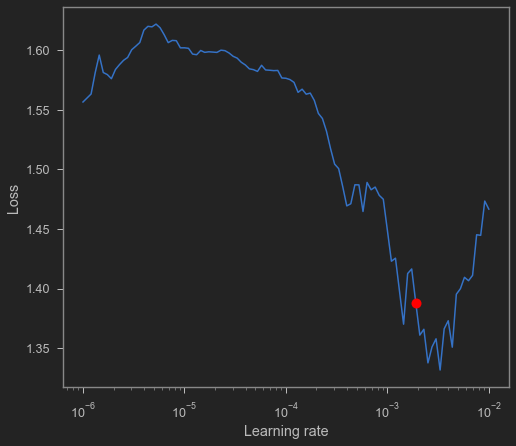

In [34]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [36]:
new_lr = lr_finder.suggestion()
model.hparams.lr = new_lr
model.hparams.lr

0.0019054607179632462

In [ ]:
#trainer.fit(model, dm)